In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt  
from copy import deepcopy
from preprocessing import Preprocess
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import sqrt
import scipy.io
import warnings

warnings.filterwarnings("ignore")

In [17]:
#Rule Object structure
class rule_object():
    def __init__(self,complete_rules,prem_terms,rules,wd_,index):
        self.complete_rules = complete_rules
        self.prem_terms = prem_terms
        self.rules = rules
        self.index = index
        self.wd_ = wd_

In [18]:
#dataset = pd.read_csv('series/multivariate-time-series-data-master/exchange_rate/exchange_rate.txt',header=None)
mat = scipy.io.loadmat('cluster4.mat')
dataset = mat.get('cluster4')[:,1:4]

In [ ]:
mat

In [ ]:
pd.DataFrame(dataset, columns=['0', '1', '2', '3', '4']).corr()

In [ ]:
dataset

In [ ]:
'''
MA = 5
MA_values = np.zeros((dataset.shape[0]-MA,dataset.shape[1]))
for i in range(dataset.shape[1]):
    a = dataset[i].rolling(window=MA).mean().values
    MA_values[:,i] = a[5:]
MA_dataset = pd.DataFrame(MA_values)
'''

In [19]:
#Basic informations 

num_predictors = 60
num_input = 12
lag = 24
lag_notused = np.array([[4,5],[4,5],[4],[4,5]])
not_used_lag = False

#Actually, lag stands for all inputs for each serie. Example, lag = 2 uses s(t) and s(t-1) to predict s(t+1)
diff_series = False
detrend_series = False

In [20]:
#We are going to split between training, validation and test set.
#Training set: 2 months of data (168*60) + lag
#Validation set: 168 steps (1 week)
#Test set: 168 steps (1 week)

h_test = 18
h_val = 18
#h_train = dataset.shape[0] - h_val - h_test - lag - 2
h_train = dataset.shape[0] - h_test - h_val

a = dataset.shape[0] #quantidade de dados
all_data = dataset[lag:,:] 
training_data = dataset[lag:lag+h_train,:]
test_data = dataset[a - h_test:a,:]

In [ ]:
h_test

In [ ]:
dataset.shape[0]

In [ ]:
all_data.shape

In [ ]:
test_data.shape

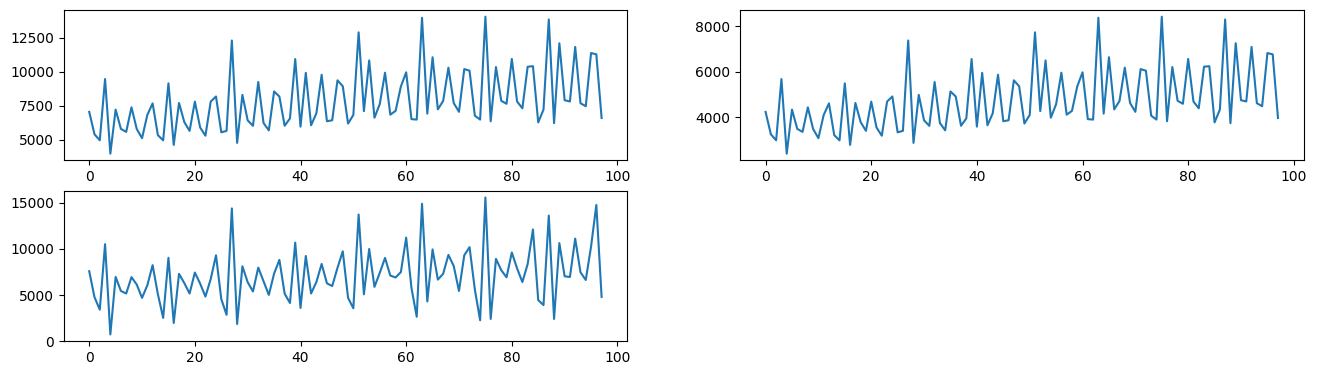

In [21]:
plt.figure(figsize=(16,9))
for n in range(training_data.shape[1]):
    plt.subplot(4,2,n+1)
    plt.plot(training_data[:,n])

In [23]:
#data = data1[:,[0, 61, 147, 241]]
#data_ = training_values[:,[0,6]]
#data_ = training_values[:,[0,2,6,7]]
data_ = training_data
#data_ = training_values[:,[0, 61, 147, 241]]

In [24]:
#bin_values = 12; #Representação da binarização do tempo.
num_series = data_.shape[1]  #Numero de series do problema, extraído dos dados

max_rulesize = 3 #Max numbers of premises rules.
min_activation = 0.5 #Minimum activation

form_method = 'nmean'
split_method = 'FCD'
solve_method = 'mqr'
#####Definicao de funcoes######
#detrend_method = ''
#bin_method = ''

fuzzy_method = 'mfdef_cluster'
num_groups = 7

defuzz_method = 'height'

ensemble_rules = None

total_number = data_.shape[1]*lag


filepath = 'results V2'

In [ ]:
data_.shape

In [54]:
# data_: dados de treino (removendo lag inicial)
#Normalize data 
scaler = StandardScaler()
#scaler = MinMaxScaler()
preprocess_data = Preprocess(data_,h_prev=h_val,num_series=num_series, lag=lag, target_position=1)

#For training set
#training_set_orig, val_set_orig = preprocess_data.diff_series()
training_set, val_set = preprocess_data.split_data()
correlation_array = preprocess_data.spearman_corr_weights()
autocorrelation_matrix = preprocess_data.linear_acf_weights()
#training_set_orig, val_set_orig, trends = preprocess_data.detrend_series()

#diff_data = np.concatenate((training_set_orig, val_set_orig))

#norm_data = scaler.fit_transform(diff_data)
#training_set = scaler.transform(training_set_orig)
#val_set = scaler.transform(val_set_orig)

#training_set[abs(training_set) > 3] = 0

yt, yp, yp_lagged = preprocess_data.delay_input(in_sample = training_set, lag = lag)
#For all set. This will be useful for initial values of prediction
all_yt, all_yp, all_lagged = preprocess_data.delay_input(in_sample = dataset, lag = lag)

In [ ]:
correlation_array

In [ ]:
# # all_data: dados de treino + teste (removendo o lag inicial)
# process_all = Preprocess(all_data, h_prev = h_test, num_series=num_series)
# train_val_org, test_set_orig, a_trends = process_all.detrend_series()
# detrend_data = np.concatenate((train_val_org, test_set_orig))

# #data leakage?
# norm_data = scaler.fit_transform(detrend_data)
# training_set = scaler.transform(train_val_org)
# #val_set = scaler.transform(val_set_orig)

# test_set_norm = scaler.transform(test_set_orig)
# #all_data_norm = scaler.transform(all_data)

# test_all_yt, test_all_yp, test_all_lagged = preprocess_data.delay_input(in_sample = norm_data, lag = lag)

In [ ]:
#diff_data.shape
#diff_data = data_

In [ ]:
#plt.plot(yt[:,2])
#plt.ylabel('Diff values')
#plt.xlabel('Timestamp (h)')

In [ ]:
#plt.plot(norm_data[:,2])
#plt.ylabel('Diff values')
#plt.xlabel('Timestamp (h)')

In [ ]:
#For all set. This will be useful for initial values of prediction
#all_yt, all_yp, all_lagged = preprocess_data.delay_input(in_sample = diff_data, lag = lag)

In [ ]:
#plt.plot(yt[200:,1])

In [ ]:
#assert val_set.shape[0] == h_val
#assert yp_lagged.shape[0] == h_train
#assert yt.shape[0] == h_train

In [ ]:
#dataset.shape

In [26]:
import seaborn as sns
from copy import deepcopy
from utils import *

import itertools
import json
import os

#For e-autoMFIS, we import all of them.
from eautoMFIS_V2 import autoMFIS
import numpy as np
import scipy.io
from reweight import Reweight
from fuzzyfication import Fuzzification
from defuzzification import Defuzzification
import matplotlib.pyplot as plt
from predict import predict, predict_pattern



def convert_object_to_float(data,datanames):
    
    for name in datanames:
        dname = data[name].values.astype('str')
        dname = [new_value.replace(',','.') for new_value in dname]
        data[name] = dname
        data[name] = data[name].astype(float)
    return data

##Assertion for ensemble rules
#Somehow, when appending rules, ensemble_rules[:,1] has a erroneous form. This part seems to normalize it.

#This module correct this error. Also, we are going to use some assertion to check if rules contains the same antecedents.
def correct_bug(ensemble_rules,max_rulesize=0):
    correct_rule = []
    d_stacked_rules = []
    new_ensemble_rules = np.zeros(shape=ensemble_rules.shape, dtype=object)


    for  n_times in range(ensemble_rules.shape[1]):
        t_rules = ensemble_rules[:,n_times]
        correct_rule = []
        d_stacked_rules = []
        k = 0
        for rule in t_rules:
            #print(rule)
            #print(len(rule))
            #Check if there's a rule bigger than max_rulesize + 1 (#antecedents + #consequent)
            if len(rule) > max_rulesize + 1:
                #print(rule)
                for i in rule:
                    #k += 1
                    if isinstance(i,tuple):
                        #print(i)
                        correct_rule.append(i)
                    else:
                        if len(correct_rule) == 0:
                            #print(i)
                            pass
                            #d_stacked_rules.append(i)
                        else:
                            #print(correct_rule)
                            new_ensemble_rules[k,n_times] = correct_rule
                            k += 1
                            #d_stacked_rules.append(correct_rule)
                            correct_rule = []
                            #d_stacked_rules.append(i)
            else:
                new_ensemble_rules[k,n_times] = rule
                k += 1
                #d_stacked_rules.append(rule)
            
        #new_ensemble_rules[:,i] = np.array(d_stacked_rules)

    return new_ensemble_rules

def remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents):
    t_rules = deepcopy(new_ensemble_rules[:,0])
    no_duplicated_ensemble = np.zeros(new_ensemble_rules.shape,dtype=object)
    no_duplicated_prem_terms = np.zeros(ensemble_prem_terms.shape)
    no_duplicated_antecedents = np.zeros(ensemble_antecedents.shape,dtype=object)
    new_t_rules = None

    k = 0
    j = 0
    for rule in t_rules:
        if new_t_rules is None:
            new_t_rules = [rule]
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1

        elif not check_duplicate_rules(rule,new_t_rules):
            new_t_rules.append(rule)
            no_duplicated_ensemble[k,:] = deepcopy(new_ensemble_rules[j,:])
            no_duplicated_prem_terms[k,:] = deepcopy(ensemble_prem_terms[j,:])
            no_duplicated_antecedents[k,:] = deepcopy(ensemble_antecedents[j,:])
            k += 1
        j += 1

    new_rules = deepcopy(no_duplicated_ensemble[:k,:])
    new_prem_terms = deepcopy(no_duplicated_prem_terms[:k,:])
    new_antecedents = deepcopy(no_duplicated_antecedents[:k,:])

    return new_rules, new_prem_terms, new_antecedents



In [ ]:
#t = [a + n for n in range(0,data.shape[0]-168,168) for a in range(24)]
#t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]
#yp = deepcopy(yp[t_lagged,:])
#yt = deepcopy(yt[t_lagged,:])
#yp_lagged = deepcopy(yp_lagged[t_lagged,:])

#data = deepcopy(data[t[len(t)-len(t_lagged):],:])
#in_sample = data[:data.shape[0]-h_prev,:]
#out_sample = data[data.shape[0]-h_prev:,:]

#print(len(t_lagged))

In [27]:
##Fuzzificacao
def fuzzy_transform(fuzzy_method, num_series, training_set, num_groups, yp, yt, yp_lagged, lag):
    
    Fuzzyfy = Fuzzification(fuzzy_method)

    #Lembrete: 
    #axis 0 - Registros da série
    #axis 1 - Valor de pertinência ao conjunto Fuzzy
    #axis 2 - Numero de séries

    first_time = True
    for n in range(num_series):
        
        _, mf_params = Fuzzyfy.fuzzify(training_set[:,n],np.array([]),num_groups=num_groups)
        mX, _ = Fuzzyfy.fuzzify(yp[:,n],mf_params,num_groups=num_groups)
        mY, _ = Fuzzyfy.fuzzify(yt[:,n],mf_params,num_groups=num_groups)
        if first_time:
            mX_ = np.ndarray([mX.shape[0],mX.shape[1], num_series])
            mY_ = np.ndarray([mY.shape[0],mY.shape[1], num_series])
            mf_params_ = np.ndarray([mf_params.shape[0],num_series])
            first_time = False
        mX_[:,:,n] = mX
        mY_[:,:,n] = mY
        mf_params_[:,n] = mf_params.ravel()
        #print(mf_params)
        #print(mX.shape)


    mX_lagged_ = np.ndarray([mX_.shape[0],mX_.shape[1],yp_lagged.shape[1]])
    for i in range(num_series):
        mf_params = mf_params_[:,i]
        for j in range(lag):
            mX, _ = Fuzzyfy.fuzzify(yp_lagged[:,i*lag+j],mf_params,num_groups=num_groups)
            mX_lagged_[:,:,i*lag+j] = mX
            #print(i*lag+j)


    #mX_lagged_[:,:,not_select_subsample] = 0

    #print(mX_lagged_[:,:,not_select_subsample])
    ############## Formulacao
    if not_used_lag:
        new_mX, lags_used = remove_lags(mX_lagged_,lag_notused,num_series,lag)
    else:
        new_mX = mX_lagged_
    
    return Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_



In [ ]:
all_lagged[yp_lagged.shape[0],:].reshape(1,-1).shape

In [ ]:
all_lagged.shape

Shape of in-sample is 80
Shape of lagged data is 55
Shape of validation set is 18
Predict on validation set - #0
0.24816231218768736
errors: [[1.85740681e+03 1.11436332e+03 3.18376507e+03]
 [1.62794609e+03 9.76711567e+02 2.44265082e+03]
 [1.73277374e-01 1.73270080e-01 3.54169931e-01]]
RRSE Errors = [1627.94608744  976.7115667  2442.65081565]
RRSE Errors = [1627.94608744  976.7115667  2442.65081565]
Predict on validation set - #1
0.21010914149564477
errors: [[2.25304240e+03 1.35183054e+03 2.30248855e+03]
 [1.45848451e+03 8.75047984e+02 1.68050392e+03]
 [1.37983807e-01 1.37973293e-01 2.35888729e-01]]
RRSE Errors = [1458.48450797  875.04798352 1680.50391573]
RRSE Errors = [1458.48450797  875.04798352 1680.50391573]
Predict on validation set - #2
0.21673649095626052
errors: [[1.77348733e+03 1.06412226e+03 2.94862042e+03]
 [1.43068740e+03 8.58477592e+02 2.15869294e+03]
 [1.45386254e-01 1.45401173e-01 3.40005251e-01]]
RRSE Errors = [1430.68739919  858.47759231 2158.69294272]
RRSE Errors = [1

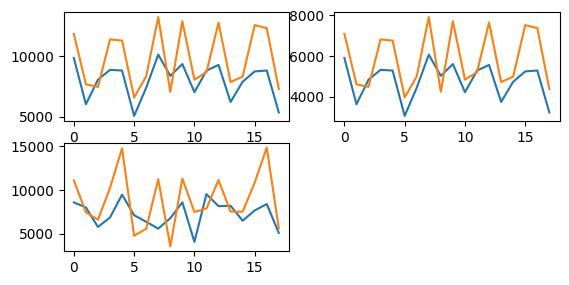

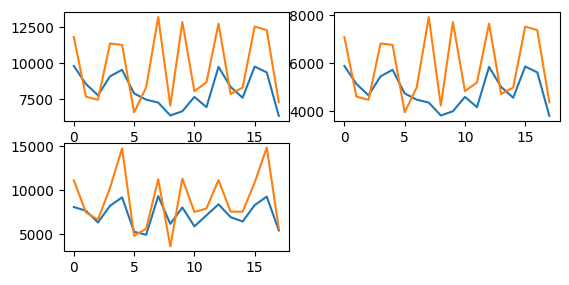

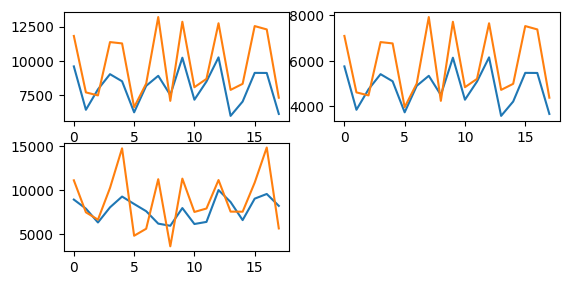

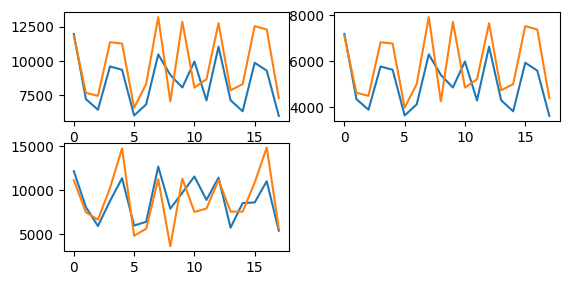

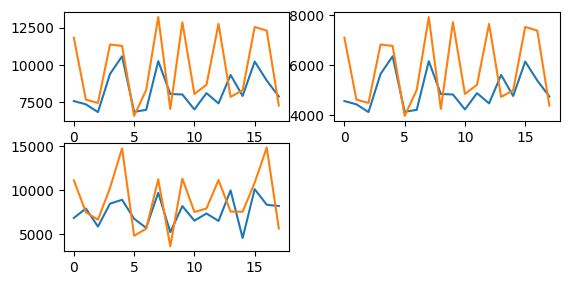

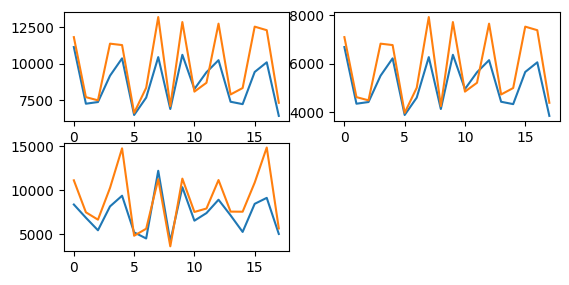

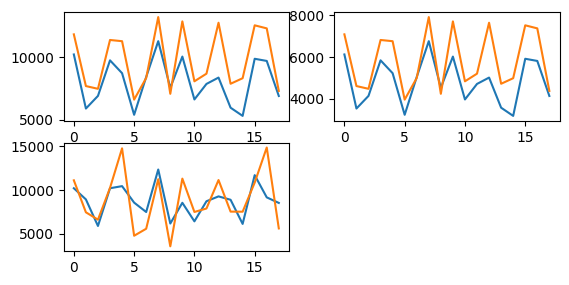

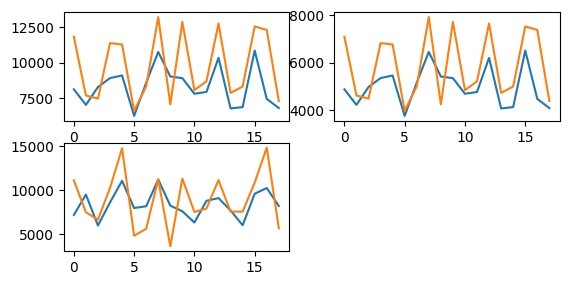

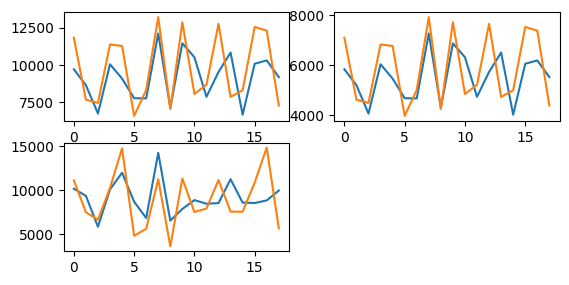

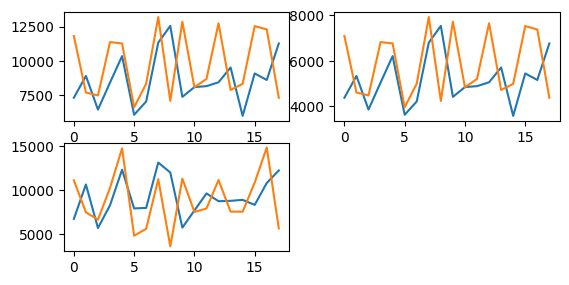

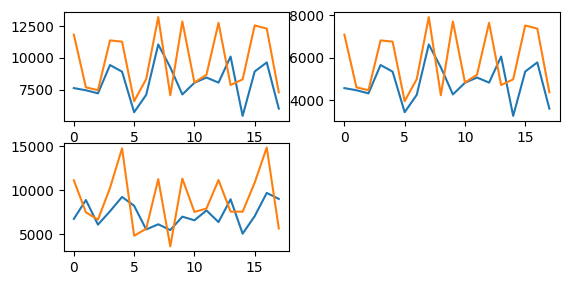

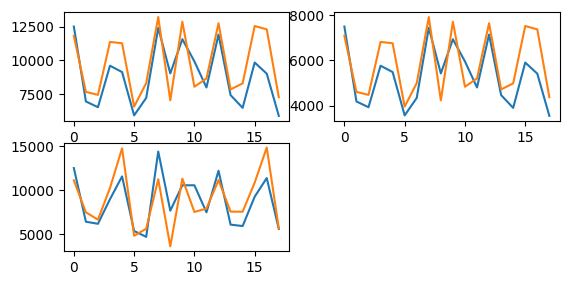

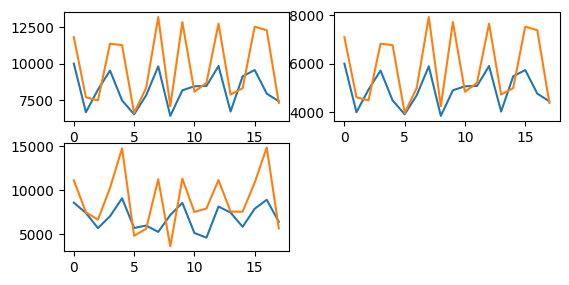

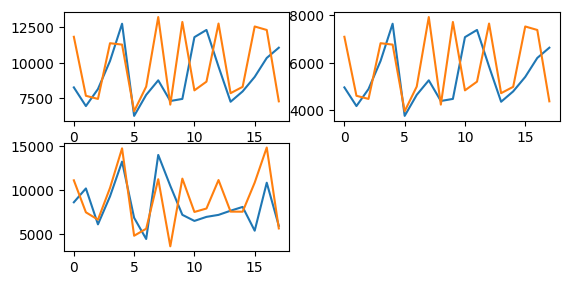

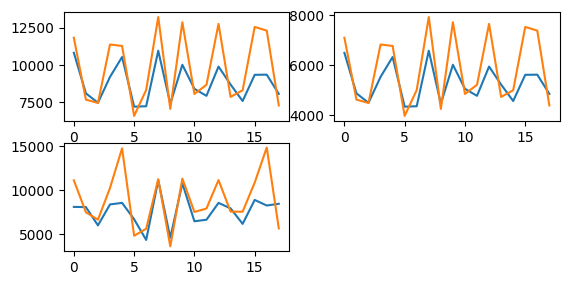

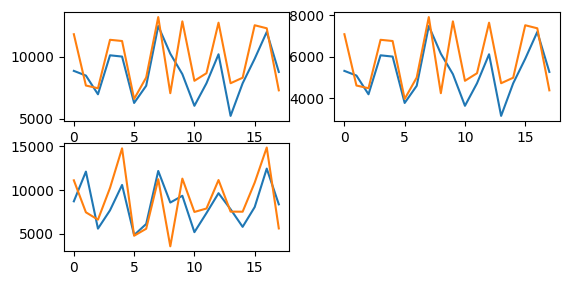

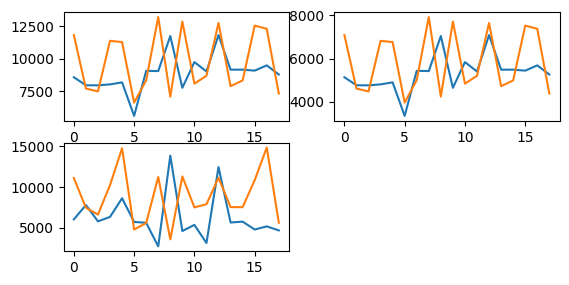

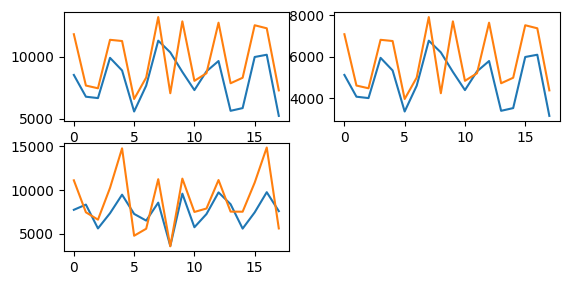

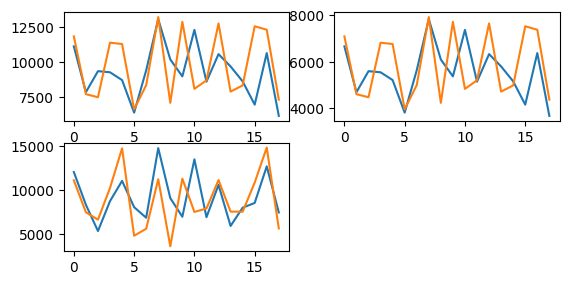

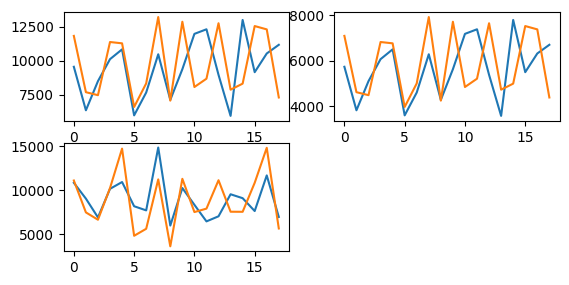

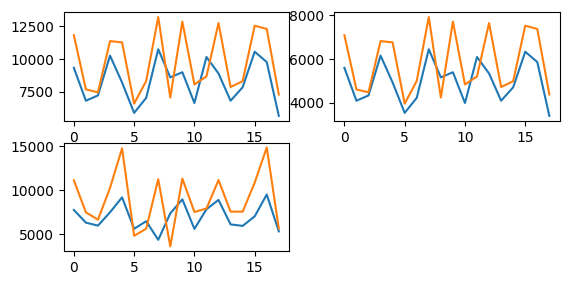

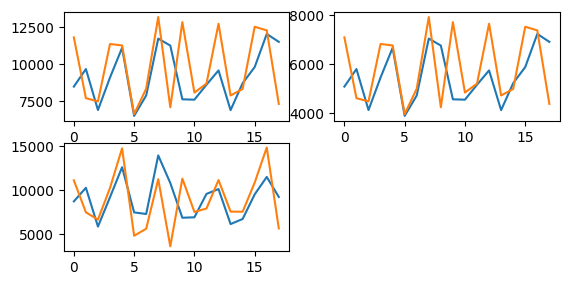

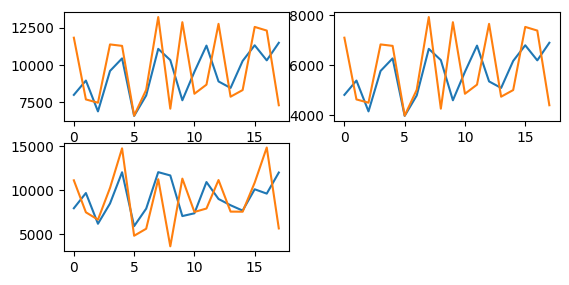

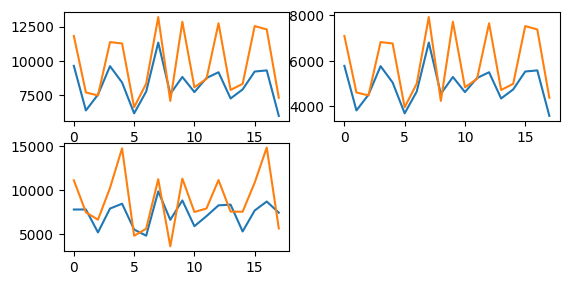

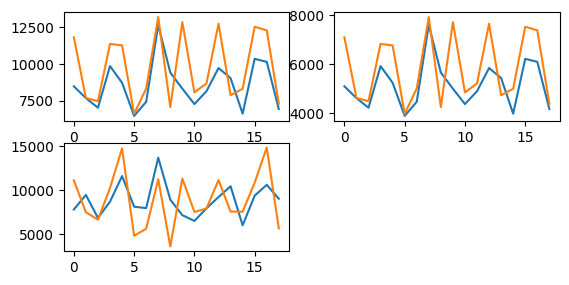

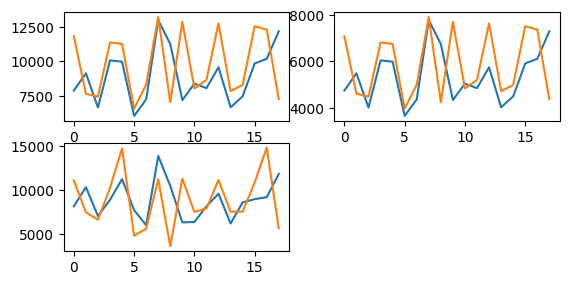

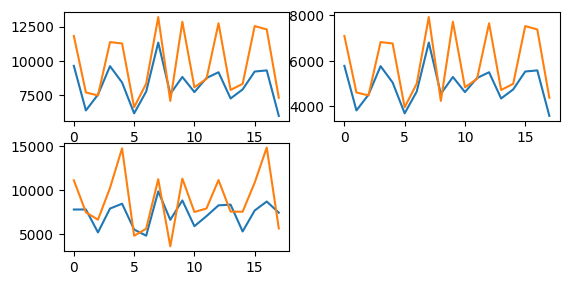

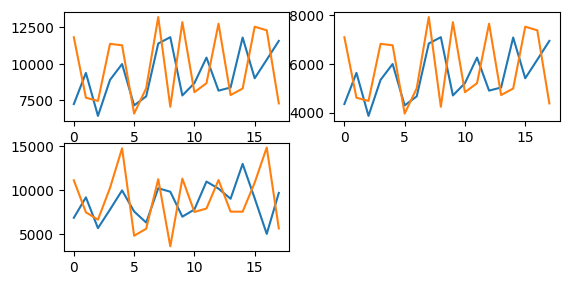

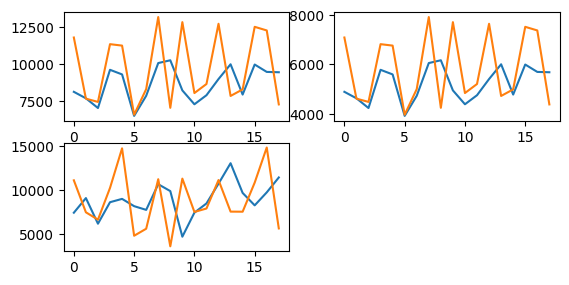

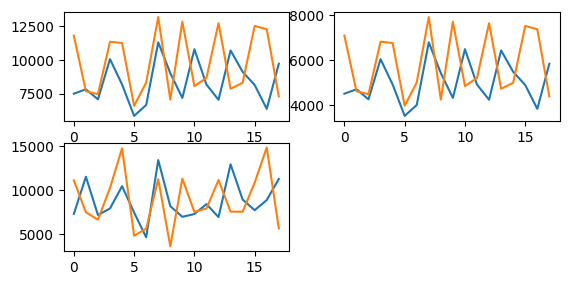

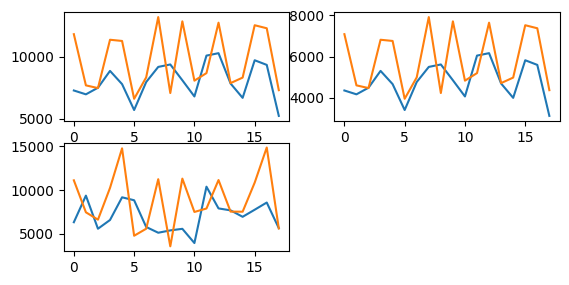

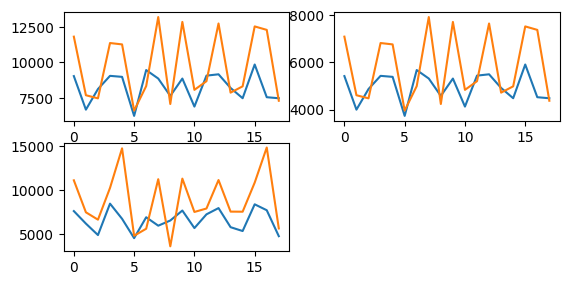

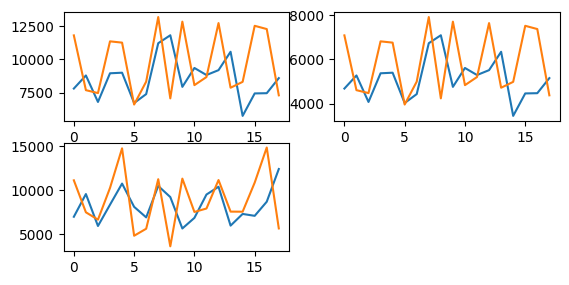

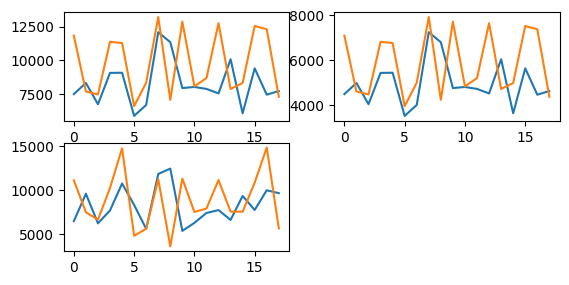

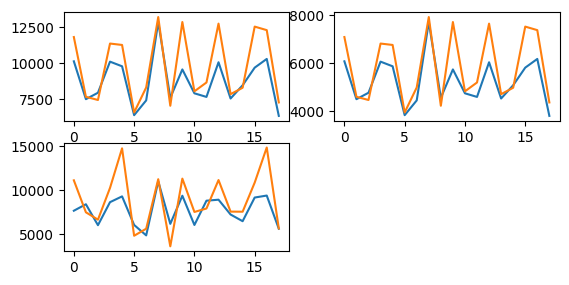

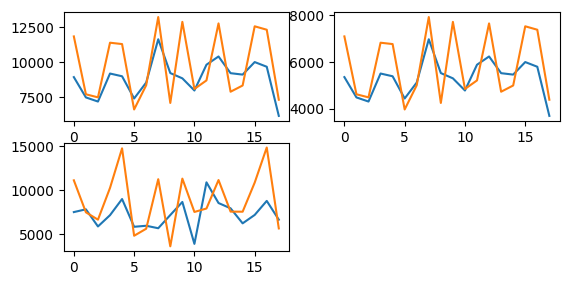

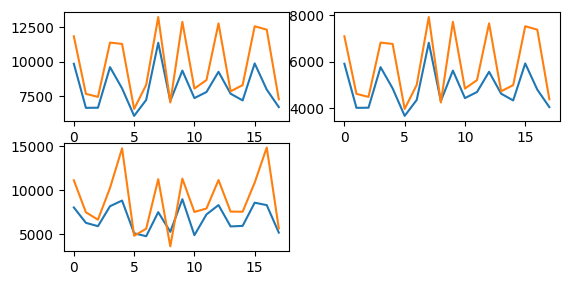

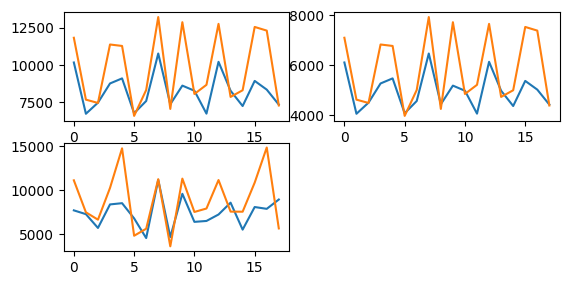

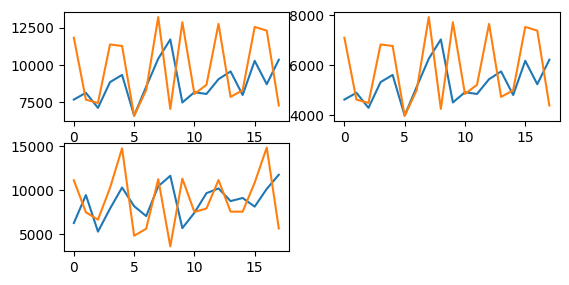

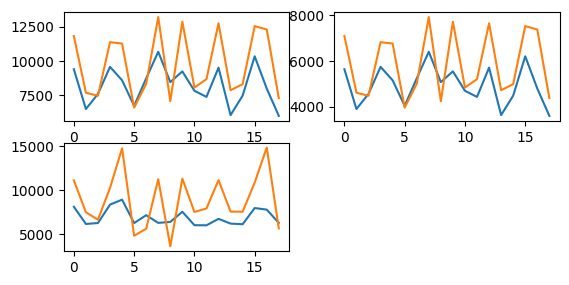

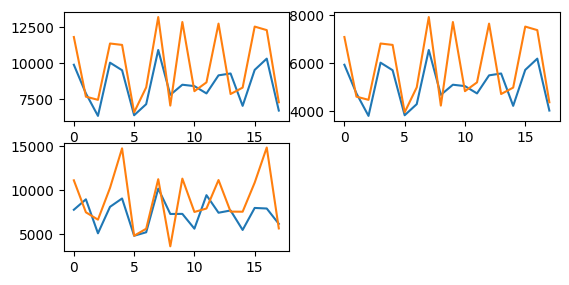

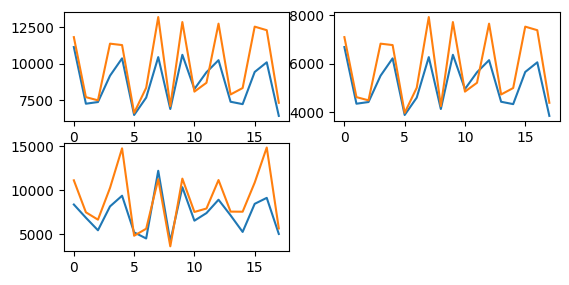

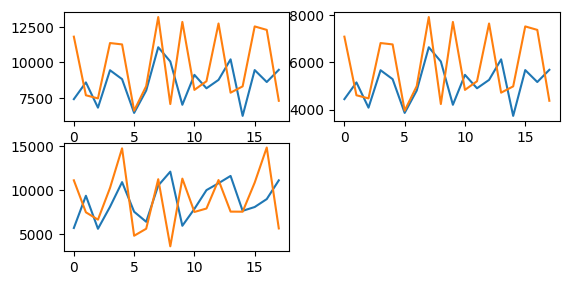

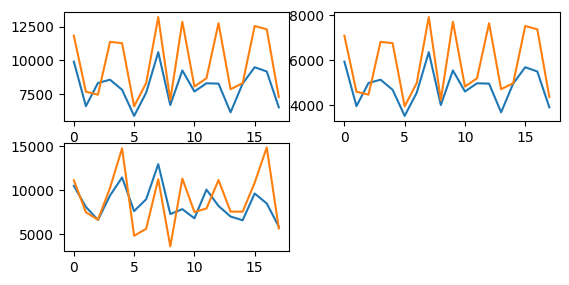

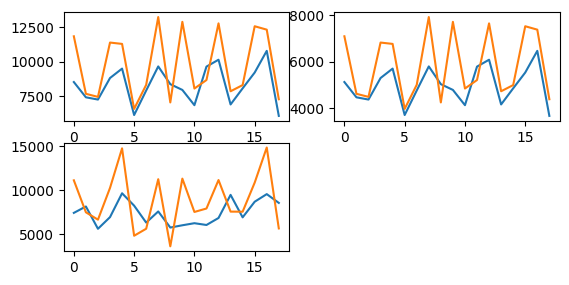

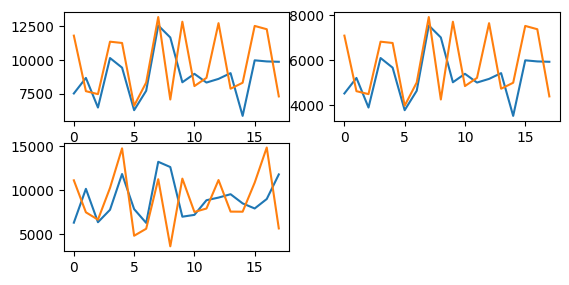

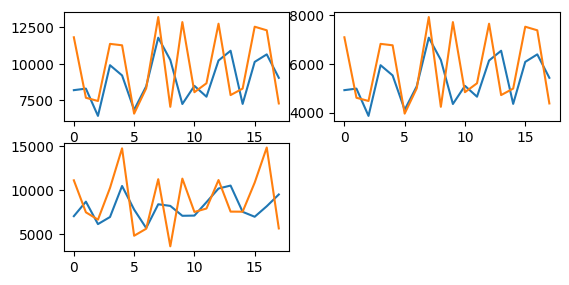

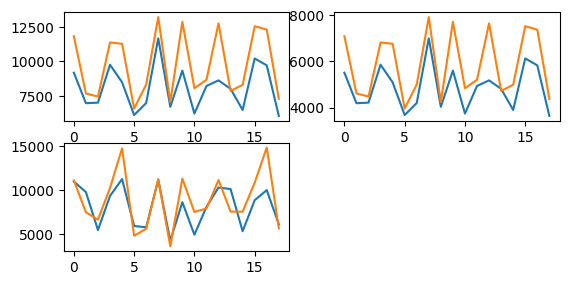

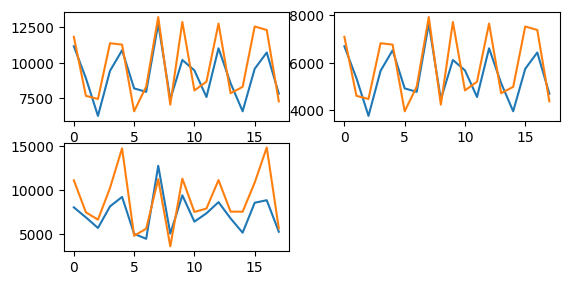

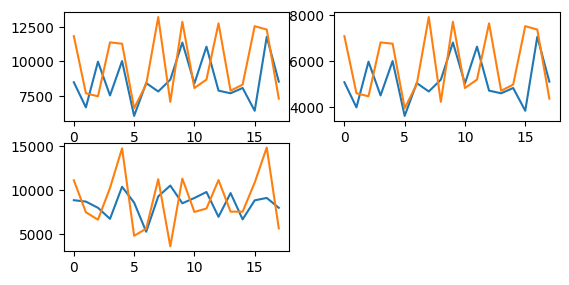

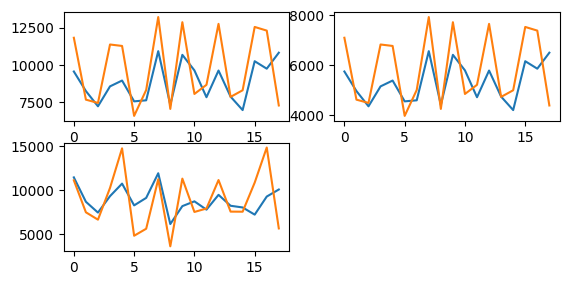

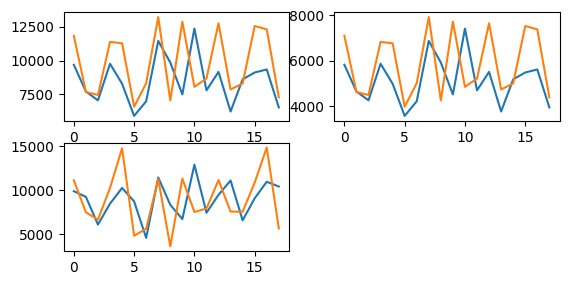

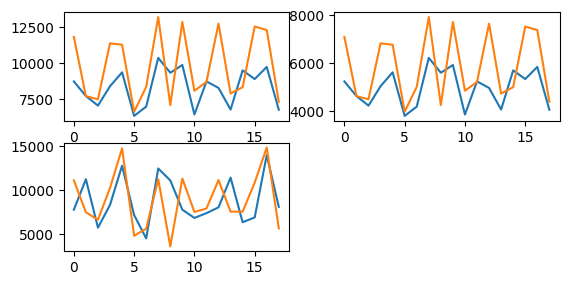

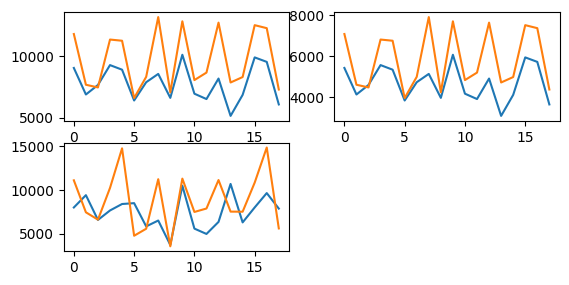

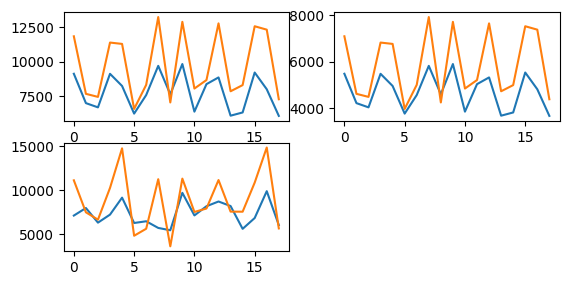

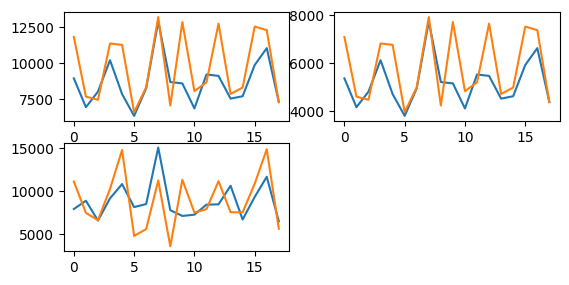

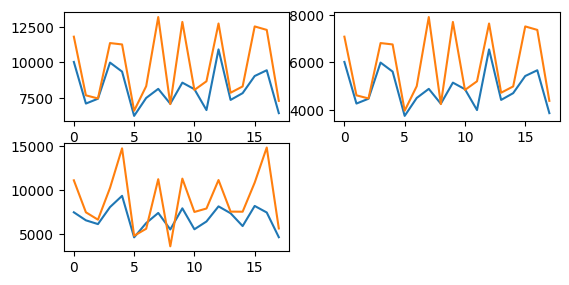

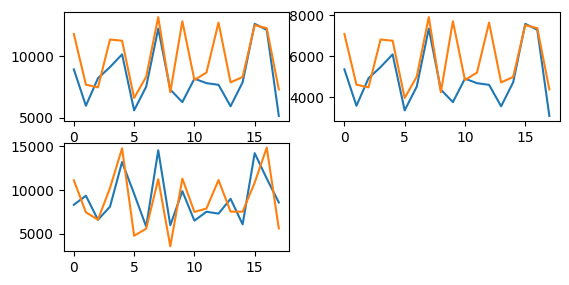

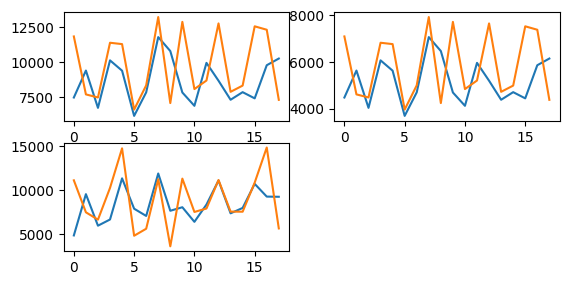

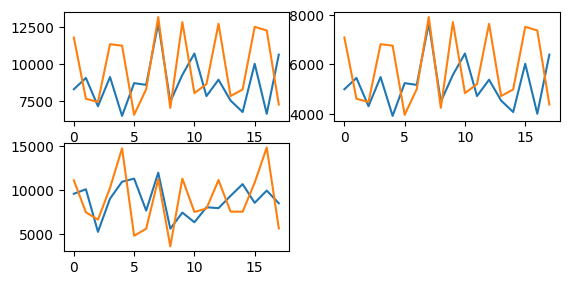

In [28]:
'''
min_error - variável a ser subsituída pelos melhores resultads obtidos  na etapa de validação
bres - melhor resultado obtido ao final da execução de todos o comitê de previsores
initial_values - Não entendi pq pega a esta linha em específico para o predict(?)
in_sample - dados de treinamento
out_sample - dados de teste (a confirmr)
num_predictors - total de previsores (regras formadas) no ensemble
'''

min_error = 300.0

bres = min_error

initial_values = all_lagged[yp_lagged.shape[0],:].reshape(1,-1)
in_sample = deepcopy(training_set)
out_sample = deepcopy(val_set)


print('='*89)

print(f'Shape of in-sample is {in_sample.shape[0]}')
#assert in_sample.shape[0] == h_train//7
print(f'Shape of lagged data is {yp_lagged.shape[0]}')
#assert yp_lagged1.shape[0] == h_train//manual_pattern
print(f'Shape of validation set is {out_sample.shape[0]}')

print('='*89)


#num_predictors = 1

#Concatenate rules
for i in range(num_predictors):
    
    try:
        _, _, yp_lagged_ = preprocess_data.generate_subsamples(correlation_array=correlation_array,
                                                               autocorrelation_matrix=autocorrelation_matrix,
                                                               num_inputs=num_input, 
                                                               in_sample=in_sample, 
                                                               yt = yt, 
                                                               yp = yp, 
                                                               yp_lagged = deepcopy(yp_lagged))

        Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_ = fuzzy_transform(fuzzy_method, num_series, training_set, num_groups, yp, yt, deepcopy(yp_lagged_), lag)
        
        model = autoMFIS(diff_series=diff_series,
                         detrend_series=detrend_series,
                         fuzzy_method=fuzzy_method,
                         solve_method=solve_method,
                         defuzz_method=defuzz_method, 
                         num_groups = num_groups,
                         inputs=num_input, 
                         h_prev = out_sample.shape[0], 
                         num_series = num_series, 
                         max_rulesize = max_rulesize, 
                         min_activation = min_activation, 
                         lag = lag,
                         target_position=1, 
                         hide_values = False, 
                         form_method = form_method, 
                         split_method = split_method, 
                         show=False)

        model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, deepcopy(mX_lagged_)) 

        # not_select_subsample = np.random.choice(total_number,total_number-num_input,replace=False)
        # t_mX_lagged = deepcopy(mX_lagged_)
        # t_mX_lagged[:,:,not_select_subsample] = 0

        # model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, t_mX_lagged)        

        t_mX_lagged, complete_rules, prem_terms, rules, agg_training, wd_ = model.train(dataset,
                                                                                        correlation_array = correlation_array,
                                                                                        autocorrelation_matrix = autocorrelation_matrix,
                                                                                        in_sample=in_sample,
                                                                                        out_sample=out_sample,
                                                                                        lag_notused=[],
                                                                                        debug=False)



        #complete_rules, prem_terms, rules, agg_training, wd_ = autoMFIS(data_,lag=lag, lag_notused=lag_notused, not_used_lag=not_used_lag,not_select_subsample=not_select_subsample, h_prev = out_sample.shape[0], diff_series=diff_series, detrend_series=detrend_series, num_series=num_series, max_rulesize=max_rulesize, min_activation=min_activation, fuzzy_method=fuzzy_method, num_groups=num_groups,solve_method='mqr',defuzz_method=defuzz_method,yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample)
        print('='*89)
        print(f'Predict on validation set - #{i}')
        #Prediction of a single subset
        #yt_totest, errors = model.predict(initial_values, data=norm_data, in_sample = yt, out_sample=val_set, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'p_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=min_error, fig_axis=[4,2],ndata=MA_dataset,show=False)
        predicted_values = np.zeros(test_data.shape)
        yt_totest, errors = model.predict(initial_values,
                                          correlation_array = correlation_array,
                                          autocorrelation_matrix = autocorrelation_matrix, 
                                          data=dataset, 
                                          in_sample = yt, 
                                          out_sample=val_set, 
                                          agg_training=agg_training,
                                          h_prev=h_test,
                                          n_attempt=f'p_subsample_{i}',
                                          wd_=wd_,
                                          ensemble_antecedents=rules,
                                          ensemble_rules=complete_rules, 
                                          filepath=filepath, 
                                          lim=min_error, 
                                          fig_axis=[4,2],
                                          ndata=['1', '2'],
                                          show=False,
                                          plot_image = True)
        #real_yt = scaler.inverse_transform(yt_totest)
        real_yt = deepcopy(yt_totest)
        #errors = smape(real_yt,test_data)
        res = np.mean(2*abs(test_data-real_yt) / (abs(real_yt) + abs(test_data)))
        print(res)
        print(f'errors: {errors}')
        print('='*89)
        if res < bres:
            bres = res 
            y_best = yt_totest 
            best_complete_rules = complete_rules
            best_prem_terms = prem_terms
            best_rules = rules
            best_agg_training = agg_training 
            best_wd_ = wd_
            best_t_mx_lagged = t_mX_lagged 

        plt.figure()
        for n in range(real_yt.shape[1]):
            plt.subplot(3,2,n+1)
            plt.plot(real_yt[:,n])
            plt.plot(test_data[:,n])
        #print(complete_rules)
        
        if errors[1,0] < 1800:
            if ensemble_rules is None:
                ensemble_rules = complete_rules
                ensemble_prem_terms = prem_terms
                ensemble_antecedents = rules
                #print(ensemble_rules.shape)
            else:
                ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
                
                ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
                ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
                #print(ensemble_rules.shape)
                #print(ensemble_prem_terms.shape)
            #print(ensemble_rules[:,0])
        elif ensemble_rules is None and i == num_predictors - 1:
            ensemble_rules = complete_rules
            ensemble_prem_terms = prem_terms
            ensemble_antecedents = rules
            print('No rules match criteria. Using rules to fill the gap')
        #print('RMSE Errors = {}'.format(errors[0,:]))
        print('RRSE Errors = {}'.format(errors[1,:]))
        #print('Mean RRSE Error = {}'.format(np.mean(errors[1,:])))
        
        
        print('RRSE Errors = {}'.format(errors[1,:]))
        if errors[1,0] < min_error:
            ensemble_rules = deepcopy(complete_rules)
            ensemble_prem_terms = deepcopy(prem_terms)
            ensemble_antecedents = deepcopy(rules)
            wd__ = wd_
            min_error = errors[1,0]

    except Exception as e:
        print(e)
        pass
    

In [29]:
res

0.25264815830985793

In [30]:
model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, best_t_mx_lagged)

In [31]:
best_yt_totest, best_errors = model.predict(initial_values,
                                            correlation_array = correlation_array,
                                            autocorrelation_matrix = autocorrelation_matrix, 
                                            data=dataset, 
                                            out_sample=test_data, 
                                            agg_training=best_agg_training,
                                            h_prev=h_test,
                                            n_attempt='best_model',
                                            wd_=best_wd_ ,
                                            ensemble_antecedents=best_rules,
                                            ensemble_rules=best_complete_rules,
                                            filepath=filepath,
                                            lim=min_error, 
                                            fig_axis=[4,2],
                                            ndata=dataset.shape[1],
                                            show=False,
                                            plot_image = True)

best_real_yt = deepcopy(best_yt_totest)
#errors = smape(real_yt,test_data)
best_results = np.mean(2*abs(test_data-best_real_yt) / (abs(best_real_yt) + abs(test_data)))

In [32]:
best_rules

array([[list([(27, 1)])],
       [list([(3, 2)])],
       [list([(27, 5)])],
       [list([(3, 6)])],
       [list([(10, 0)])],
       [list([(10, 6)])],
       [list([(13, 0)])],
       [list([(13, 4)])],
       [list([(61, 6)])],
       [list([(23, 3)])],
       [list([(48, 6)])],
       [list([(36, 0)])],
       [list([(36, 1)])],
       [list([(36, 6)])],
       [list([(45, 0)])],
       [list([(45, 3)])],
       [list([(45, 4)])],
       [list([(61, 3)])],
       [list([(69, 0)])],
       [list([(69, 1)])],
       [list([(69, 4)])],
       [list([(71, 0)])],
       [list([(71, 1)])],
       [list([(71, 3)])],
       [list([(48, 1)])],
       [list([(48, 4)])],
       [list([(24, 6)])],
       [list([(48, 0)])],
       [list([(27, 6)])],
       [list([(24, 2)])],
       [list([(10, 1)])],
       [list([(10, 5)])],
       [list([(61, 0)])],
       [list([(23, 0)])],
       [list([(23, 1)])],
       [list([(13, 6)])],
       [list([(45, 1)])],
       [list([(24, 5)])],
       [list([

In [33]:
best_rules.shape

(64, 1)

In [34]:
best_errors

array([[1.49190352e+03, 8.95068393e+02, 2.36083495e+03],
       [1.13211534e+03, 6.79216509e+02, 1.78058869e+03],
       [1.04649507e-01, 1.04641003e-01, 1.99392833e-01]])

In [35]:
best_results

0.1438156815932833

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

out_sample=test_data

for i in range(num_series):
    idx = np.where(np.isnan(yt_totest[:,i]))

    if len(idx) > 0:
        best_yt_totest[:,i] = pd.DataFrame(best_yt_totest[:,i]).fillna(method='bfill').values.ravel()

if diff_series:
    #Y__ = yt_totest + data[in_sample.shape[0]:data.shape[0]-1,:]
    #Yt__ = out_sample + data[in_sample.shape[0]:data.shape[0]-1,:]
    y_pp = np.roll(best_yt_totest,1,axis=0)
    y_pp[0,:] = dataset[in_sample.shape[0],:]
    y_tt = np.roll(out_sample,1,axis=0)
    y_tt[0,:] = dataset[in_sample.shape[0],:]
    Y__ = best_yt_totest + y_pp
    Yt__ = out_sample + y_tt
    print('diff series')

elif detrend_series:
    Y__ = best_yt_totest + trends[in_sample.shape[0]:,:]
    Yt__ = out_sample + trends[in_sample.shape[0]:,:]

else:
    Y__ = best_yt_totest
    Yt__ = out_sample
errors = np.zeros(shape=(3,num_series))
rmse = sqrt(mean_squared_error(Yt__[:,0], Y__[:,0]))
mae = mean_absolute_error(Yt__[:,0], Y__[:,0])
MAPE = mape(Yt__[:, 0], Y__[:, 0])
errors[0,0] = rmse
errors[1,0] = mae
errors[2, 0] = MAPE

with open('results V2/best_model.txt','w') as f:
    for i in range(num_series):
        rmse = sqrt(mean_squared_error(Y__[:,i], Yt__[:,i]))
        mae = mean_absolute_error(Y__[:,i], Yt__[:,i])
        MAPE = mape(Yt__[:, i], Y__[:, i])
        #rrse_error = rrse(Y__[:,i], Yt__[:,i])

        #print('Outsample RRSE for serie {} is {} \n'.format(i+1,rrse_error), file=f)
        print('Outsample RMSE for serie {} is {} \n'.format(i+1,rmse), file=f)
        print('Outsample MAE for serie {} is {} \n'.format(i+1,mae), file=f)
        #print('Outsample SMAPE for serie {} is {} \n'.format(i+1,smape(Yt__[:,i],Y__[:,i])),file=f)
        print('Outsample MAPE for serie {} is {} \n'.format(i + 1, 100*MAPE), file=f)
        errors[0,i] = rmse
        errors[1, i] = mae
        errors[2, i] = MAPE
        #errors[1,i] = rrse_error

plt.figure(figsize=(16*3,10*2))
k = 1

fig_axis=[3,2]

for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title(['1', '2'],fontsize=32)
    plt.plot(best_yt_totest[:,i],color='orange')
    plt.plot(out_sample[:,i],color='blue')
    plt.legend(['Previsto','Real'], fontsize=26)
    plt.xlabel('Tempo(h)',fontsize=26)
    plt.ylabel('Valor',fontsize=26)
    k += 1


plt.savefig('results V2/best_model.png')    #plt.show()
plt.close()

In [37]:
model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, mX_lagged_)
ensemble_wd_, ensemble_agg_training = model.reweight_mf(mY_,ensemble_rules,ensemble_prem_terms)

In [38]:
ensemble_yt_totest, ensemble_errors = model.predict(initial_values,
                                                    correlation_array = correlation_array,
                                                    autocorrelation_matrix = autocorrelation_matrix, 
                                                    data=dataset, 
                                                    out_sample=test_data, 
                                                    agg_training=ensemble_agg_training,
                                                    h_prev=h_test,
                                                    n_attempt='ensemble_model',
                                                    wd_=ensemble_wd_ ,
                                                    ensemble_antecedents=ensemble_antecedents,
                                                    ensemble_rules=ensemble_rules,
                                                    filepath=filepath,
                                                    lim=min_error, 
                                                    fig_axis=[4,2],
                                                    ndata=[],
                                                    show=False,
                                                    plot_image = True)

ensemble_real_yt = deepcopy(ensemble_yt_totest)
#errors = smape(real_yt,test_data)
ensemble_results = np.mean(2*abs(test_data-ensemble_real_yt) / (abs(ensemble_real_yt) + abs(test_data)))

In [39]:
ensemble_rules

array([[list([(48, 6), (0, 0)]), list([(48, 6), (1, 0)]),
        list([(48, 6), (2, 0)])],
       [list([(48, 0), (0, 6)]), list([(48, 0), (1, 6)]),
        list([(48, 0), (2, 6)])],
       [list([(48, 1), (0, 5)]), list([(48, 1), (1, 5)]),
        list([(48, 1), (2, 0)])],
       ...,
       [list([(1, 0), (23, 1), (51, 0), (0, 2)]),
        list([(1, 0), (23, 1), (51, 0), (1, 2)]),
        list([(1, 0), (23, 1), (51, 0), (2, 2)])],
       [list([(11, 3), (20, 0), (27, 1), (0, 4)]),
        list([(11, 3), (20, 0), (27, 1), (1, 4)]),
        list([(11, 3), (20, 0), (27, 1), (2, 3)])],
       [list([(63, 3), (0, 6)]), list([(63, 3), (1, 6)]),
        list([(63, 3), (2, 6)])]], dtype=object)

In [40]:
ensemble_rules.shape

(2764, 3)

In [41]:
ensemble_errors

array([[1.77966648e+03, 1.06770738e+03, 3.26384128e+03],
       [1.44078189e+03, 8.64400882e+02, 2.50650573e+03],
       [1.47564050e-01, 1.47553522e-01, 2.64637825e-01]])

In [42]:
ensemble_results

0.1960400019508406

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

for i in range(num_series):
    idx = np.where(np.isnan(yt_totest[:,i]))

    if len(idx) > 0:
        ensemble_yt_totest[:,i] = pd.DataFrame(ensemble_yt_totest[:,i]).fillna(method='bfill').values.ravel()

if diff_series:
    #Y__ = yt_totest + data[in_sample.shape[0]:data.shape[0]-1,:]
    #Yt__ = out_sample + data[in_sample.shape[0]:data.shape[0]-1,:]
    y_pp = np.roll(ensemble_yt_totest,1,axis=0)
    y_pp[0,:] = dataset[in_sample.shape[0],:]
    y_tt = np.roll(out_sample,1,axis=0)
    y_tt[0,:] = dataset[in_sample.shape[0],:]
    Y__ = ensemble_yt_totest + y_pp
    Yt__ = out_sample + y_tt
    print('diff series')

elif detrend_series:
    Y__ = ensemble_yt_totest + trends[in_sample.shape[0]:,:]
    Yt__ = out_sample + trends[in_sample.shape[0]:,:]

else:
    Y__ = ensemble_yt_totest
    Yt__ = out_sample
errors = np.zeros(shape=(3,num_series))
rmse = sqrt(mean_squared_error(Yt__[:,0], Y__[:,0]))
mae = mean_absolute_error(Yt__[:,0], Y__[:,0])
MAPE = mape(Yt__[:, 0], Y__[:, 0])
errors[0,0] = rmse
errors[1,0] = mae
errors[2, 0] = MAPE

with open('results V2/ensemble_model.txt','w') as f:
    for i in range(num_series):
        rmse = sqrt(mean_squared_error(Y__[:,i], Yt__[:,i]))
        mae = mean_absolute_error(Y__[:,i], Yt__[:,i])
        MAPE = mape(Yt__[:, i], Y__[:, i])
        #rrse_error = rrse(Y__[:,i], Yt__[:,i])

        #print('Outsample RRSE for serie {} is {} \n'.format(i+1,rrse_error), file=f)
        print('Outsample RMSE for serie {} is {} \n'.format(i+1,rmse), file=f)
        print('Outsample MAE for serie {} is {} \n'.format(i+1,mae), file=f)
        #print('Outsample SMAPE for serie {} is {} \n'.format(i+1,smape(Yt__[:,i],Y__[:,i])),file=f)
        print('Outsample MAPE for serie {} is {} \n'.format(i + 1, 100*MAPE), file=f)
        errors[0,i] = rmse
        errors[1, i] = mae
        errors[2, i] = MAPE
        #errors[1,i] = rrse_error

plt.figure(figsize=(16*3,10*2))
k = 1

fig_axis=[3,2]

for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title(['1', '2'],fontsize=20)
    plt.plot(ensemble_yt_totest[:,i],color='orange')
    plt.plot(out_sample[:,i],color='blue')
    plt.legend(['Previsto','Real'])
    plt.xlabel('Tempo(h)',fontsize=15)
    plt.ylabel('Valor',fontsize=15)
    k += 1


plt.savefig('results V2/ensemble_model.png')    #plt.show()
plt.close()

In [59]:
cnt = 0
list_remove = []

dict_val = {}

for i in range(ensemble_prem_terms.shape[0]):
    except_one = np.copy(ensemble_prem_terms)
    v = except_one[i,:]
    idx = np.argwhere(v > 0.5).ravel()
    v = v[idx]
    rest = np.delete(except_one, i, axis=0)
    rest = rest[:,idx]
    cpare = np.tile(v,(rest.shape[0],1))
    m = np.minimum(rest,cpare) 
    M = np.maximum(rest,cpare) + 10e-15
    res = m/M
    mean = np.mean(res,axis=1)
    #plt.figure()
    #plt.hist(mean)
    
    vv = np.argwhere(mean > 0.6).ravel()

    if vv.shape[0] > 0:    
        vv[vv > i] += 1
        vv2 = np.append(vv,np.array([i]))

        eval_v = ensemble_prem_terms[vv2][:,idx]

        t = np.mean(eval_v,axis=1)

        keep_val = vv2[np.argmax(t)]
        vmax = np.max(t)
        print(f'{keep_val} : {vmax}')
        if keep_val not in list_remove:
            dict_val[keep_val] = 1
            list_remove.append(keep_val)
        else:
            dict_val[keep_val] = dict_val[keep_val] + 1

        cnt += np.argwhere(mean > 0.6).shape[0]

58 : 0.9302976181068139
55 : 0.8520337672685716
56 : 0.7934725755744227
57 : 0.7414673688085294
59 : 0.8520337672685716
60 : 0.7934725755744227
61 : 0.715743322791891
62 : 0.9302976181068139
104 : 0.8337592449633989
9 : 0.9302976181068139
319 : 0.8273727284800002
322 : 0.9302976181068139
254 : 0.9070634908090852
72 : 0.8520337672685716
73 : 0.8516042159431635
15 : 0.9070634908090852
75 : 0.8520337672685716
76 : 0.8516042159431635
77 : 0.7176547325392157
79 : 0.9070634908090852
407 : 0.8259056525892032
21 : 0.8605952362136278
775 : 0.8585633580523664
765 : 0.8605952362136278
348 : 0.8259056525892032
83 : 0.7234195612866254
389 : 0.8349905843944275
114 : 0.7933101321897958
2181 : 0.8521257721362402
371 : 0.8521257721362402
0 : 0.9302976181068139
88 : 0.8520337672685716
96 : 0.8316516175827472
345 : 0.8585633580523664
113 : 0.7448048078038733
81 : 0.8311593856224567
82 : 0.8560434653789396
780 : 0.8259056525892032
26 : 1.0
353 : 0.794184286291488
29 : 0.9241272357936164
666 : 0.8337592449

In [60]:
ensemble_prem_terms[0, :]

array([0.        , 0.        , 0.        , 0.93923564, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06127013, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.78195483, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.18976908, 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ])

In [61]:
filtered_rules = deepcopy(ensemble_rules[list_remove,:])
filtered_prems = deepcopy(ensemble_prem_terms[list_remove,:])
filtered_antecedents = deepcopy(ensemble_antecedents[list_remove,:])

In [62]:
model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, mX_lagged_)
filtered_wd_, filtered_agg_training = model.reweight_mf(mY_,filtered_rules,filtered_prems)

In [63]:
filtered_yt_totest, filtered_errors = model.predict(initial_values,
                                                    correlation_array = correlation_array,
                                                    autocorrelation_matrix = autocorrelation_matrix, 
                                                    data=dataset, 
                                                    out_sample=test_data, 
                                                    agg_training=filtered_agg_training,
                                                    h_prev=h_test,
                                                    n_attempt='filtered_model',
                                                    wd_=filtered_wd_,
                                                    ensemble_antecedents=filtered_antecedents,
                                                    ensemble_rules=filtered_rules, 
                                                    filepath=filepath, lim=min_error,
                                                    fig_axis=[4,2],
                                                    ndata=[],
                                                    show=False,
                                                    plot_image = True)

filtered_real_yt = deepcopy(filtered_yt_totest)
#errors = smape(real_yt,test_data)
filtered_results = np.mean(2*abs(test_data-filtered_real_yt) / (abs(filtered_real_yt) + abs(test_data)))

In [64]:
filtered_rules.shape

(322, 3)

In [65]:
filtered_errors

array([[2.18726954e+03, 1.31234604e+03, 2.42753273e+03],
       [1.60276376e+03, 9.61645955e+02, 1.85024321e+03],
       [1.46225769e-01, 1.46222827e-01, 2.08541130e-01]])

In [66]:
filtered_results

0.1796807958502151

In [68]:
for i in range(num_series):
    idx = np.where(np.isnan(yt_totest[:,i]))

    if len(idx) > 0:
        filtered_yt_totest[:,i] = pd.DataFrame(filtered_yt_totest[:,i]).fillna(method='bfill').values.ravel()

if diff_series:
    #Y__ = yt_totest + data[in_sample.shape[0]:data.shape[0]-1,:]
    #Yt__ = out_sample + data[in_sample.shape[0]:data.shape[0]-1,:]
    y_pp = np.roll(filtered_yt_totest,1,axis=0)
    y_pp[0,:] = dataset[in_sample.shape[0],:]
    y_tt = np.roll(out_sample,1,axis=0)
    y_tt[0,:] = dataset[in_sample.shape[0],:]
    Y__ = filtered_yt_totest + y_pp
    Yt__ = out_sample + y_tt
    print('diff series')

elif detrend_series:
    Y__ = filtered_yt_totest + trends[in_sample.shape[0]:,:]
    Yt__ = out_sample + trends[in_sample.shape[0]:,:]

else:
    Y__ = filtered_yt_totest
    Yt__ = out_sample
errors = np.zeros(shape=(3,num_series))
rmse = sqrt(mean_squared_error(Yt__[:,0], Y__[:,0]))
mae = mean_absolute_error(Yt__[:,0], Y__[:,0])
MAPE = mape(Yt__[:, 0], Y__[:, 0])
errors[0,0] = rmse
errors[1,0] = mae
errors[2, 0] = MAPE

with open('results V2/filtered_model.txt','w') as f:
    for i in range(num_series):
        rmse = sqrt(mean_squared_error(Y__[:,i], Yt__[:,i]))
        mae = mean_absolute_error(Y__[:,i], Yt__[:,i])
        MAPE = mape(Yt__[:, i], Y__[:, i])
        #rrse_error = rrse(Y__[:,i], Yt__[:,i])

        #print('Outsample RRSE for serie {} is {} \n'.format(i+1,rrse_error), file=f)
        print('Outsample RMSE for serie {} is {} \n'.format(i+1,rmse), file=f)
        print('Outsample MAE for serie {} is {} \n'.format(i+1,mae), file=f)
        #print('Outsample SMAPE for serie {} is {} \n'.format(i+1,smape(Yt__[:,i],Y__[:,i])),file=f)
        print('Outsample MAPE for serie {} is {} \n'.format(i + 1, 100*MAPE), file=f)
        errors[0,i] = rmse
        errors[1, i] = mae
        errors[2, i] = MAPE
        #errors[1,i] = rrse_error

plt.figure(figsize=(16*3,10*2))
k = 1

fig_axis=[3,2]

for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title(['1', '2'],fontsize=20)
    plt.plot(filtered_yt_totest[:,i],color='orange')
    plt.plot(out_sample[:,i],color='blue')
    plt.legend(['Previsto','Real'])
    plt.xlabel('Tempo(h)',fontsize=15)
    plt.ylabel('Valor',fontsize=15)
    k += 1


plt.savefig('results V2/filtered_model.png')    #plt.show()
plt.close()

In [ ]:
#Basic imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from math import sqrt
from copy import deepcopy

#Imports from sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

#autoMFIS modules imports
from fuzzyfication import Fuzzification
from tnorm import tnorm_product
from formulation import Formulation
from split import Split
from reweight import Reweight
from defuzzification import Defuzzification
from metrics import mape, smape
from preprocessing import Preprocess
from basicfuzzy import trimf, trapmf
from utils import *
from metrics import rrse

#Predict imports
from predict import plot_predict, plot_training

#Some functions.
#TODO - Check if these functions are already on utils module.

def remove_lags(mX_lagged_,lag_notused,num_series,lag):
    assert num_series == lag_notused.shape[0]
    lags_used = np.array(lag_notused)
    for n in range(num_series):
        lag_serie = lag_notused[n]
        lin = np.linspace(0,lag-1,lag)
        lag_used = np.setdiff1d(lin,lag_serie) + n*lag
        lag_used = [int(f) for f in lag_used]
        lags_used[n] = lag_used
        print(lag_used)
        if n == 0:
            new_mX = mX_lagged_[:,:,lag_used[:]]   
            #print(new_mX.shape) 
        else:
            new_mX = np.concatenate((new_mX,mX_lagged_[:,:,lag_used]),axis=2)
    
    return new_mX, lags_used


class autoMFIS2():
    '''
    Automatic Fuzzy System for multivariate time series forecasting.
    
    \n Parameters are divided into methods, booleans and numeric parameters.
    \n Methods:
    \n - fuzzy_method: Method for fuzzy set generation. Options: 'mfdef_triangle' (uniform division of fuzzy sets), 'mfdef_cluster' (division of centers by clustering method).
    \n - form_method: Method for formulation evaluation. Options: 'freq' (frequency), 'mean' (mean of activation), 'nmean' (non-zero mean of activation).
    \n - solve_method: Method for optimization problem. Options: 'None' (skip reweight), 'mqr' (Constrained optimization).
    \n - defuzz_method: Method for defuzzification. Options: 'cog' (center of gravity), 'mom' (mean of maximum), 'height' (height method).
    
    \n Boolean parameters:
    \n - diff_series: If true, use diff series preprocessing.
    \n - detrend_series: If true, use detrend series preprocessing.
    \n - hide_values: If true, mask some desired series.

    \n Numeric parameters:
    \n - num_groups: Number of group sets during fuzzification.
    \n - h_prev: Prediction horizon, relative to the problem.
    \n - num_series: Number of input series.
    \n - min_activation: Min. activation to be elected as antecedent rule.
    \n - max_rulesize: Max. of antencedents
    \n - lag: Max. lags.
    '''
    def __init__(self,diff_series=False,detrend_series=False,fuzzy_method='mfdef_triangle',solve_method='None',defuzz_method='mom', num_groups = 5,
        h_prev = 1, num_series = 1, max_rulesize = 5, min_activation = 0.5, lag = 1, hide_values = False, form_method = 'nmean', show=False, split_method = 'FCD'):
        self.diff_series = diff_series
        self.detrend_series = detrend_series

        self.fuzzy_method = fuzzy_method
        self.solve_method = solve_method 
        self.defuzz_method = defuzz_method
        self.num_groups = num_groups
        self.form_method = form_method
        self.hide_values = hide_values
        self.split_method = split_method

        self.h_prev = h_prev
        self.num_series = num_series 
        self.max_rulesize = max_rulesize
        self.min_activation = min_activation
        self.lag = lag 
        self.show = show

        self.set_fuzzy = False

    def set_fuzzification(self, Fuzzify, mf_params, mX, mY, mX_lagged):
        self.set_fuzzy = True
        self.Fuzzify = Fuzzify
        self.mf_params = mf_params
        self.mX = mX
        self.mY = mY
        self.mX_lagged = mX_lagged

    def train(self, data, yt=None,yp=[],yp_lagged=[],in_sample=None,out_sample=[],not_select_subsample=[], lag_notused=[],debug=False):
        '''
        Training step for autoMFIS. It's divided into 6 steps, namely:
        \n - 0. Preprocessing (if not given)
        \n - 1. Fuzzification
        \n - 2. Formulation
        \n - 3. Splitting
        \n - 4. Reweight
        \n - 5. Defuzzification
        '''
        #Preprocessing
        if in_sample is None:
            print('In-sample not given to autoMFIS module. Running preprocessing...')
            prep = Preprocess(data, h_prev = self.h_prev, num_series = self.num_series)
            in_sample, out_sample = prep.split_data()
            yt, yp, yp_lagged = prep.delay_input(in_sample = in_sample, lag = self.lag)


        #Fuzzificacao
        #Lembrete: 
        #axis 0 - Registros da série
        #axis 1 - Valor de pertinência ao conjunto Fuzzy
        #axis 2 - Numero de séries
        if debug:
            print('Step 1 - Fuzzification')
        
        Fuzzify, mf_params_, mX_, mY_, mX_lagged_ = self.fuzzify(in_sample, yp, yt, yp_lagged, not_select_subsample)
        
        #assert (mX_lagged_[:,:,not_select_subsample] == 0).all(), "Cant hide subsample"

        #print(np.unique(mX_))
        #print(np.unique(mY_))
        #print(np.unique(mX_lagged_))
        #print(mX_lagged_[:,:,not_select_subsample])
        ############## Formulacao
        
        if self.hide_values:
            new_mX, _lags_used = remove_lags(mX_lagged_,lag_notused,self.num_series,self.lag)

        else:
            new_mX = mX_lagged_
        
        #print(np.unique(new_mX))
        #Formulation
        if debug:
            print('Step 2 - Formulation')
        rules, prem_terms = self.formulate(new_mX)

        #Splitting method
        if debug:
            print('Step 3 - Split')
        complete_rules = self.split_(mY_, prem_terms, rules)

        return complete_rules, prem_terms, rules
    


    def fuzzify(self,in_sample, yp, yt, yp_lagged, not_select_subsample):

        if self.set_fuzzy:
            Fuzzify = self.Fuzzify
            mf_params_ = self.mf_params

            mX_ = self.mX
            mY_ = self.mY
            mX_lagged_ = self.mX_lagged

            #mX_lagged_[:,:,not_select_subsample] = 0


        else:
            print('Fuzzy not given')
            Fuzzify = Fuzzification(self.fuzzy_method)
            self.Fuzzify = Fuzzify
            first_time = True
            for n in range(self.num_series):
                
                _, mf_params = Fuzzify.fuzzify(in_sample[:,n],np.array([]),num_groups=self.num_groups)
                mX, _ = Fuzzify.fuzzify(yp[:,n],mf_params,num_groups=self.num_groups)
                mY, _ = Fuzzify.fuzzify(yt[:,n],mf_params,num_groups=self.num_groups)
                if first_time:
                    mX_ = np.ndarray([mX.shape[0],mX.shape[1], self.num_series])
                    mY_ = np.ndarray([mY.shape[0],mY.shape[1], self.num_series])
                    mf_params_ = np.ndarray([mf_params.shape[0], self.num_series])
                    first_time = False
                mX_[:,:,n] = mX
                mY_[:,:,n] = mY
                mf_params_[:,n] = mf_params.ravel()
                #print(mf_params)
                #print(mX.shape)

            #self.mf_params = mf_params
            #self.mf_params_ = mf_params_
            self.mX_ = mX_
            self.mY_ = mY_ 

            mX_lagged_ = np.ndarray([mX_.shape[0],mX_.shape[1],yp_lagged.shape[1]])
            for i in range(self.num_series):
                mf_params = mf_params_[:,i]
                for j in range(self.lag):
                    mX, _ = Fuzzify.fuzzify(yp_lagged[:,i*self.lag+j],mf_params,num_groups=self.num_groups)
                    mX_lagged_[:,:,i*self.lag+j] = mX
                    #print(i*lag+j)
            mX_lagged_[:,:,not_select_subsample] = 0




        return Fuzzify, mf_params_, mX_, mY_, mX_lagged_

    def formulate(self, new_mX):
        form = Formulation(self.max_rulesize,self.min_activation,self.form_method)
        rules, _, prem_terms = form.run(new_mX)
        return rules, prem_terms

    def split_(self, mY_, prem_terms, rules):
        split = Split(mY_,prem_terms,self.num_series)
        complete_rules = split.run(rules, min_activation = self.min_activation, method=self.split_method)
        return complete_rules

    def reweight_mf(self, mY_,complete_rules,prem_terms):
        rw = Reweight(mY_,complete_rules,prem_terms)
        wd_, agg_training = rw.run(self.solve_method,debug=False)

        return wd_, agg_training

    def defuzzify(self, mf_params_, agg_training):
        defuzz = Defuzzification(mf_params_,self.num_series)
        _y_predict = defuzz.run(self.defuzz_method,agg_training,show=self.show)


    def predict(self, initial_values, lags_used = [], ndata=[''], data=[], in_sample=[], out_sample=[], agg_training=None,h_prev=0,n_attempt=0,wd_=[],ensemble_antecedents=[],ensemble_rules=[],not_used_lag = False, filepath='',lim=0, fig_axis=[3,2], show = False, plot_image = True):
        '''
        Module to time series forecasting. It uses multi-stepping in order to evaluate the model.
        INPUTS:
        \n - Fuzzify: Object containing informations about Fuzzification.
        \n - lags_used: If not_used_lags is true, masks series that isn't in list.
        \n - num_groups: Number of fuzzy sets.
        \n - ndata: name of data (e.g. column header)
        \n - data: data of the problem
        \n - in_sample: in_sample set of data
        \n - out_sample: out_sample set of data
        \n - lag:
        \n - mf_params: Membership function parameters
        \n - agg_training: Aggregation terms in training set. Used to simplify deffuzification of training set.
        \n - yp_lagged
        \n - h_prev:
        #TODO - Continue this list

        VARIABLES:
        \n - y_predict_: Training set prediction
        \n - yp_totest: Input pattern to evaluate prediction
        \n - yt_totest: Output data, for each horizon and serie.
        '''
        
        defuzz = Defuzzification(self.mf_params,self.num_series)
        if agg_training is not None:
            y_predict_ = defuzz.run(self.defuzz_method,agg_training)

        yp_totest = initial_values
        yt_totest = np.zeros((h_prev,self.num_series))

        #Prediction - Multi-step
        for h_p in range(h_prev):

            #Check activated terms.
            mX_values_in = np.zeros((1,self.mf_params.shape[0],yp_totest.shape[1]))
            antecedents_activated = []
            it = 0
            for i in range(self.num_series):
                mf_params = self.mf_params[:,i]
                for j in range(self.lag):
                    mX, _ = self.Fuzzify.fuzzify(np.array([yp_totest[0,i*self.lag+j]]),mf_params,num_groups=self.num_groups)
                    mX_values_in[:,:,i*self.lag+j] = mX

                    idx_nonzero = np.where(mX[0,:] > 0)
                    idx_nonzero = idx_nonzero[0]

                    if not_used_lag:
                        for k in range(idx_nonzero.shape[0]):
                            if j in lags_used[i]:
                                antecedents_activated.append((it,idx_nonzero[k]))
                            else:
                                pass
                        it += 1
                    
                    else:
                        for k in range(idx_nonzero.shape[0]):
                            antecedents_activated.append((i*self.lag+j,idx_nonzero[k]))

            '''
            if not_used_lag:
                mX_values_in, _ = remove_lags(mX_values_in,lag_notused,num_series,lag)


            prem_terms_test = np.zeros((ensemble_antecedents.shape[0],1))
            '''
            rules_idx = []
            check_idx = 0
            #Checking for every rule in dataset if it's activated
            #TODO - Check if we can modify this into enumerate, avoiding check_idx += 1 every time.
            for n_rule in ensemble_antecedents:
                #print('Rule {} is {}'.format(check_idx,test(n_rule,antecedents_activated)))
                if test(n_rule,antecedents_activated):
                    rules_idx.append(check_idx)
                check_idx += 1
                
            prem_activated = np.zeros((ensemble_antecedents.shape[0],))
            for i in rules_idx:
                prem_activated[i,] = prem_term(ensemble_antecedents[i,0],mX_values_in)
            
            agg_test = np.zeros((wd_.shape))
            for i in range(self.num_series):
                for j in rules_idx:
                    rule = ensemble_rules[j,i]
                    consequent = rule[-1]
                    agg_test[j,consequent[1],i] = prem_activated[j,]
                    
            weight_agg = np.multiply(agg_test,wd_)
            weight_ = np.zeros((weight_agg.shape[1],weight_agg.shape[2]))
            for i in range(weight_.shape[1]):
                weight_[:,i] = weight_agg[:,:,i].max(axis=0)

            w_todefuzz = np.reshape(weight_,(1,weight_.shape[0],weight_.shape[1]))
            
            #Defuzzification in fact
            y_pred = defuzz.run(self.defuzz_method,w_todefuzz,show=show)
            
            #Store predicted value into yt_totest.
            yt_totest[h_p,:] = y_pred
            
            #Last step, we use the predicted output to compose input data.
            y_temp = np.zeros(yp_totest.shape)
            assert y_temp.shape == yp_totest.shape
            y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]
            for ii in range(self.num_series):
                #print(yp_totest[0,ii*lag])
                #print(y_pred[0][ii])
                #yp_totest[0,ii*lag] = y_pred[0][ii]
                y_temp[0,ii*self.lag] = y_pred[0][ii]
                #print(yp_totest[0,yp_totest.shape[1]-1])
            yp_totest = y_temp

        #Plot training results
        #plot_training(y_predict_=y_predict_,num_series=self.num_series,in_sample=in_sample,lag=self.lag,ndata=ndata,data=data,trends=[],filename='{}/Insample {}'.format(filepath,n_attempt),fig_axis=fig_axis)
        '''
        plt.figure(figsize=(16,10))
        
        for i in range(self.num_series):
            plt.subplot(fig_axis[0],fig_axis[1],i+1)
            #plt.title('Serie {}'.format(ndata.columns[i]),fontsize=30)
            plt.plot(y_predict_[:,i],color='blue')
            plt.plot(in_sample[:,i],color='red')
            plt.legend(['Predicted','Target'])
            plt.xlabel('Time(h)',fontsize=15)
            plt.ylabel('Value',fontsize=15)
        plt.savefig('results/{}/In_sample{}.png'.format(filepath,n_attempt))
        #plt.show()
        plt.close()
        '''
        #Plot predicted results and returns error metrics
        if plot_image:
            errors = plot_predict(lim=lim,yt_totest=yt_totest,num_series=self.num_series,data=data,out_sample=out_sample,trends=[],ndata=ndata,filename='{}/Outsample {}'.format(filepath,n_attempt), fig_axis=fig_axis)
        else:
            errors = None
        return yt_totest, errors






    def predict_pattern(self, initial_values, lags_used = [], ndata=[''], data=[], out_sample=[],h_prev=0,n_attempt=0,not_used_lag = False, filepath='',lim=0, defuzz_method='cog',fig_axis=[3,2], n_patterns=0, list_rules=None, wd_given=True):
        '''
        Function for pattern prediction. 
        \n Important features: 
        \n - n_pattern: Number of seasonal patterns.
        \n - list_rules: list of rules for each pattern.
        '''

        #preprocess_data = Preprocess(data,h_prev=h_prev,num_series=num_series)
        
        #in_sample, out_sample = preprocess_data.split_data()
        
        #yt, yp, yp_lagged = preprocess_data.delay_input(in_sample = in_sample, lag = lag)


        defuzz = Defuzzification(self.mf_params,self.num_series)

        yp_totest = initial_values
        yt_totest = np.zeros((h_prev,self.num_series))

        for h_p in range(h_prev):
            print('='*89)
            #Select which ruleset use now.

            rem = h_p % 168

            k = rem // 24

            print(f'Debug only, rem = {rem} and k = {k}')
            print('='*89)
            ensemble_antecedents = list_rules[k].rules
            ensemble_rules = list_rules[k].complete_rules

            #If weight matrix is not given, just fill with ones.
            if not wd_given:
                wd_ = np.ones((ensemble_rules.shape[0], self.num_groups, ensemble_rules.shape[1]))
            else:
                wd_ = list_rules[k].wd_



            print(f'Shape of ensemble rules is {ensemble_rules.shape}')

            mX_values_in = np.zeros((1,self.mf_params.shape[0],yp_totest.shape[1]))
            antecedents_activated = []
            it = 0
            for i in range(self.num_series):
                mf_params = self.mf_params[:,i]
                for j in range(self.lag):

                    mX, _ = self.Fuzzify.fuzzify(np.array([yp_totest[0,i*self.lag+j]]),mf_params,num_groups=self.num_groups)
                    mX_values_in[:,:,i*self.lag+j] = mX


                    idx_nonzero = np.where(mX[0,:] > 0)
                    idx_nonzero = idx_nonzero[0]

                    if not_used_lag:
                        for k in range(idx_nonzero.shape[0]):
                            if j in lags_used[i]:
                                antecedents_activated.append((it,idx_nonzero[k]))
                            else:
                                pass
                        it += 1
                    
                    else:
                        for k in range(idx_nonzero.shape[0]):
                            antecedents_activated.append((i*self.lag+j,idx_nonzero[k]))

            '''
            if not_used_lag:
                mX_values_in, _ = remove_lags(mX_values_in,lag_notused,num_series,lag)


            prem_terms_test = np.zeros((ensemble_antecedents.shape[0],1))
            '''
            rules_idx = []
            check_idx = 0
            
            #Checking for every rule in dataset if it's activated
            #TODO - Check if we can modify this into enumerate, avoiding check_idx += 1 every time.
            for n_rule in ensemble_antecedents:
                #print('Rule {} is {}'.format(check_idx,test(n_rule,antecedents_activated)))
                if test(n_rule,antecedents_activated):
                    rules_idx.append(check_idx)
                check_idx += 1
                
            prem_activated = np.zeros((ensemble_antecedents.shape[0],))
            for i in rules_idx:
                prem_activated[i,] = prem_term(ensemble_antecedents[i,0],mX_values_in)
            
            agg_test = np.zeros((wd_.shape))
            for i in range(self.num_series):
                for j in rules_idx:
                    rule = ensemble_rules[j,i]
                    consequent = rule[-1]
                    agg_test[j,consequent[1],i] = prem_activated[j,]
                    
                    
            weight_agg = np.multiply(agg_test,wd_)
            weight_ = np.zeros((weight_agg.shape[1],weight_agg.shape[2]))

            for i in range(weight_.shape[1]):
                weight_[:,i] = weight_agg[:,:,i].max(axis=0)

            w_todefuzz = np.reshape(weight_,(1,weight_.shape[0],weight_.shape[1]))
            
            #Defuzzification in fact
            y_pred = defuzz.run(self.defuzz_method,w_todefuzz,show=False)
            
            #Store predicted value into yt_totest.
            yt_totest[h_p,:] = y_pred
            
            #Last step, we use the predicted output to compose input data.
            y_temp = np.zeros(yp_totest.shape)
            assert y_temp.shape == yp_totest.shape
            y_temp[0,1:] = yp_totest[0,0:yp_totest.shape[1]-1]
            for ii in range(self.num_series):
                #print(yp_totest[0,ii*lag])
                #print(y_pred[0][ii])
                #yp_totest[0,ii*lag] = y_pred[0][ii]
                y_temp[0,ii*self.lag] = y_pred[0][ii]
                #print(yp_totest[0,yp_totest.shape[1]-1])
            yp_totest = y_temp

        k = 1
        for i in range(self.num_series):
            plt.subplot(fig_axis[0],fig_axis[1],k)
            plt.title('Serie {}'.format(ndata.columns[i]),fontsize=30)
            plt.plot(yt_totest[:,i],color='blue')
            plt.plot(out_sample[:,i],color='red')
            plt.legend(['Predicted','Target'])
            plt.xlabel('Time(h)',fontsize=15)
            plt.ylabel('Value',fontsize=15)
            k += 1
    


        errors = plot_predict(lim=500,yt_totest=yt_totest,num_series=self.num_series,data=data,out_sample=out_sample,trends=[],ndata=ndata,filename='{}/Outsample {}'.format(filepath,n_attempt), fig_axis=fig_axis)
        print('Finished plot predict pattern')
        return errors

    
    def predict_batch(self,data, initial_values = [], lags_used = [], ndata=[''], in_sample=[], out_sample=[], agg_training=None,h_prev=0,n_attempt=0,wd_=[],ensemble_antecedents=[],ensemble_rules=[],not_used_lag = False, filepath='',lim=0, fig_axis=[3,2], show = False):
        '''
        Data: predicted values (horizon, serie, batch)
        Input: initial data for prediction
        '''
        results = np.zeros(data.shape)
        for i in range(data.shape[2]):
            yt_totest, _ = self.predict(initial_values[:,:,i], lags_used = lags_used, ndata=ndata, in_sample=[], out_sample=data[:,:,i], h_prev=h_prev,n_attempt=0,wd_=wd_,ensemble_antecedents=ensemble_antecedents,ensemble_rules=ensemble_rules,not_used_lag = False, filepath=filepath,lim=lim, fig_axis=fig_axis, show = show)
            results[:,:,i] = deepcopy(yt_totest)



In [ ]:
model = autoMFIS2(diff_series=diff_series,
                  detrend_series=detrend_series,
                  fuzzy_method=fuzzy_method,
                  solve_method=solve_method,
                  defuzz_method=defuzz_method, 
                  num_groups = num_groups, 
                  h_prev = out_sample.shape[0], 
                  num_series = num_series, 
                  max_rulesize = max_rulesize, 
                  min_activation = min_activation, 
                  lag = lag, 
                  hide_values = False, 
                  form_method = form_method, 
                  split_method = split_method, 
                  show=False)
a,b,c = model.train(dataset, 
                    yt=yt,
                    yp=yp,
                    yp_lagged=yp_lagged,
                    in_sample=in_sample,
                    out_sample=out_sample,
                    not_select_subsample=not_select_subsample, 
                    lag_notused=[],
                    debug=True)


In [ ]:
# c[list_remove]

In [ ]:
mY_.shape

In [ ]:
#Fintering 

cnt = 0
list_remove = []

dict_val = {}

for i in range(b.shape[0]):
    except_one = np.copy(b)
    v = except_one[i,:]
    idx = np.argwhere(v > 0.5).ravel()
    v = v[idx]
    rest = np.delete(except_one, i, axis=0)
    rest = rest[:,idx]
    cpare = np.tile(v,(rest.shape[0],1))
    m = np.minimum(rest,cpare) 
    M = np.maximum(rest,cpare) + 10e-15
    res = m/M
    mean = np.mean(res,axis=1)
    #plt.figure()
    #plt.hist(mean)
    
    vv = np.argwhere(mean > 0.6).ravel()

    if vv.shape[0] > 0:    
        vv[vv > i] += 1
        vv2 = np.append(vv,np.array([i]))

        eval_v = b[vv2][:,idx]

        t = np.mean(eval_v,axis=1)

        keep_val = vv2[np.argmax(t)]
        vmax = np.max(t)
        print(f'{keep_val} : {vmax}')
        if keep_val not in list_remove:
            dict_val[keep_val] = 1
            list_remove.append(keep_val)
        else:
            dict_val[keep_val] = dict_val[keep_val] + 1

        cnt += np.argwhere(mean > 0.6).shape[0]


In [ ]:
filtered_rules = deepcopy(a[list_remove,:])
filtered_prems = deepcopy(b[list_remove,:])


In [ ]:
np.mean(eval_v,axis=1)

In [ ]:
vv

In [ ]:
print(m[0,1])
print(M[0,1])


In [ ]:
n = 0
np.mean(2*abs(test_data[:,n]-real_yt[:,n]) / (abs(real_yt[:,n]) + abs(test_data[:,n])))

In [ ]:
np.where(wd_[:,:,1] > 0.1)[0]

In [ ]:
wd_.shape

In [ ]:
predicted_values = np.zeros(test_data.shape)
init = in_sample.shape[0]
for k in range(0,h_test,24):
    print(k)
    initial_values = test_all_lagged[yp_lagged.shape[0]+k,:].reshape(1,-1)
    yt_totest, _ = model.predict(initial_values, data=norm_data, in_sample = yt, out_sample=val_set, agg_training=agg_training,h_prev=24,n_attempt=f'p_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=min_error, fig_axis=[4,2],ndata=MA_dataset,show=False)
    a = scaler.inverse_transform(yt_totest)
    b = a + a_trends[init+k:init+k+24,:]
    predicted_values[k:k+24,:] = b

In [ ]:
from math import sqrt

F = predicted_values[:1510,:]
A = test_data.values[:1510,:]     
num = sqrt(np.sum((F-A)**2))
den = sqrt(np.sum((A-np.mean(A))**2))
rrse = num/(den+0.0000001)

In [ ]:
num = sqrt(np.sum((F-A)**2))
den = sqrt(np.sum((A-np.mean(A))**2))
rrse = num/(den+0.0000001)

In [ ]:
rrse 

In [ ]:
for i in range(F.shape[1]):
    plt.figure()
    plt.plot(F[:,i])
    plt.plot(A[:,i])

In [ ]:
for i in range(data_.shape[1]):
    plt.figure()
    plt.plot(b[:,i])
    plt.plot(data_[-24:,i])
    plt.legend(['Predicted','Actual'])

In [ ]:
in_sample.shape

In [ ]:
complete_rules[:,1]

In [ ]:
k = 0
i = 0

prems_activated = np.where(prem_terms[k,:] > min_activation)[0]
mask_mY = mY_[prems_activated,:,i]
max_index = np.argmax(mY_[prems_activated,:,i],axis=1)
index, count_index = np.unique(max_index, return_counts = True)
#print(count_index)
max_id = index[np.argmax(count_index)]

In [ ]:
mask_mY[:,2][np.where(max_index == 2)[0]].mean()

In [ ]:
max_index[max_index==1].shape

In [ ]:
a,b = np.unique(max_index, return_counts=True)

In [ ]:
blah = np.array([0, 0, 1, 1])
a, b = np.unique(blah, return_counts=True)
np.argmax(b)

In [ ]:
from utils import nmean_activation, check_if_inside, check_duplicate_rules, rearranje_rules, freq_activation, mean_activation
from tnorm import tnorm_product

In [ ]:
count_tnorm = np.vstack((mX_lagged_[:,2,16],mX_lagged_[:,0,16]))
tnorm_ = tnorm_product(count_tnorm)
a,b,c = mean_activation(tnorm_,0.5)
print(a)
print(b)
print(c)

In [ ]:
complete_rules[:,0].shape

In [ ]:
np.unique(mX_lagged_)

In [ ]:
a,b,c = nmean_activation(mX_lagged_[:,3,70],0.5)
print(a)
print(b)
print(c)

In [ ]:
complete_rules

In [ ]:
'''
init = 0
for i,a in enumerate(list_rules):
    try:
        ensemble_rules = a.complete_rules
        ensemble_prem_terms = a.prem_terms
        ensemble_antecedents = a.rules
        
        new_ensemble_rules = correct_bug(ensemble_rules,max_rulesize=max_rulesize)

        new_rules, new_prem_terms, new_antecedents = remove_duplicates(new_ensemble_rules,ensemble_prem_terms,            ensemble_antecedents)

        wd_, _ = model.reweight_mf(mY_[init:init+ensemble_prem_terms.shape[1],:,:], new_rules, new_prem_terms)
        
        list_rules[i].complete_rules = new_rules
        list_rules[i].prem_terms = new_prem_terms
        list_rules[i].rules = new_antecedents
        list_rules[i].wd_ = wd_

        init += ensemble_prem_terms.shape[1]

    except Exception as e:
        print(e)
'''

In [ ]:
initial_values = all_lagged[yp_lagged.shape[0]-1,:].reshape(1,-1)

test_values = test_data.values



In [ ]:
errors1

In [ ]:
#errors = predict_pattern(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data_, lag = lag, mf_params_=mf_params_,num_series=num_series,h_prev=h_test,not_used_lag=not_used_lag,n_attempt=f'_predict_',wd_=wd_,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2], n_patterns=n_pattern, list_rules = list_rules)



In [ ]:
errors1

In [ ]:
#new_ensemble_rules = correct_bug(ensemble_rules,max_rulesize=max_rulesize)

#new_rules, new_prem_terms, new_antecedents = remove_duplicates(new_ensemble_rules,ensemble_prem_terms, ensemble_antecedents)

#rw = Reweight(mY_,new_rules,new_prem_terms)
#wd_, agg_training = rw.run('mqr',debug=False)

#predict(Fuzzyfy, lags_used = [], num_groups=num_groups, ndata=dataset, data=data,in_sample=in_sample,out_sample=out_sample, lag = lag, mf_params_=mf_params_,num_series=num_series,agg_training=agg_training,yp_lagged=yp_lagged,h_prev=h_prev,not_used_lag=not_used_lag,n_attempt='_{}'.format(i),wd_=wd_,ensemble_antecedents=new_antecedents,ensemble_rules=new_rules,filepath=filepath,lim=3.0,defuzz_method=defuzz_method,fig_axis=[2,2])

In [ ]:
#rw = Reweight(mY_,complete_rules,prem_terms)
#wd_, agg_training = rw.run('mqr',debug=False)
#defuzz = Defuzzification(mf_params_,num_series)
#y_predict_ = defuzz.run('mom',agg_training,show=True)

In [ ]:
k = 2
t = [a + n for n in range(0,data.shape[0]-168,168) for a in range(24*k,24*(k+1))]
t_lagged = [v - lag for v in t if (v-lag) > 0 and (v-lag) < yp.shape[0]]
yp1 = deepcopy(yp[t_lagged,:])
yt1 = deepcopy(yt[t_lagged,:])
yp_lagged1 = deepcopy(yp_lagged[t_lagged,:])

data1 = deepcopy(data[t[len(t)-len(t_lagged):],:])
in_sample = data1[:data1.shape[0]-h_prev,:]
out_sample = data1[data1.shape[0]-h_prev:,:]

print(len(t_lagged))


In [ ]:
ll = [rule_object(None,None,None,k) for k in range(7)]

In [ ]:
wd_.shape

In [ ]:
complete_rules.shape

In [ ]:
list_rules[1].complete_rules

In [ ]:
all_lagged.shape

In [ ]:
all_yt[yp_lagged.shape[0] + t_val[0],:]

In [ ]:
out_sample[0,:]

In [ ]:
test_set = test_data.values

In [ ]:
plt.plot(np.arange(0,training_set.shape[0]),training_set[:,0],label='Train')
plt.plot(np.arange(training_set.shape[0],training_set.shape[0]+val_set.shape[0]),val_set[:,0],color='r',label='Validation')
plt.plot(np.arange(training_set.shape[0]+val_set.shape[0], training_set.shape[0]+val_set.shape[0] + test_set.shape[0]),test_set[:,0],label='Test')
plt.xlabel('Time')
plt.ylabel('Traffic rate')
plt.title('Data split')
plt.legend(['Train','Validation','Test'])

In [ ]:
a = dataset.corr()

In [ ]:
np.sort(a[0].values)[-5:]

In [ ]:
b = a[0].values

In [ ]:
for i in np.sort(a[0].values)[-5:]:
    print(np.where(np.isclose(b,i)))

In [ ]:
type(b)